# Implementing Transformers

This notebook will walk you through the internals of implementing self attention and transformer networks.  As with recurrent networks (and unlike convolutions), there is actually relatively little that is fundamentally new in their implementation, as it all largely involves an application of existing primitives you will have already implemented in your autodiff framework.  However, there is indeed one aspect of an efficient implementation that requires a slight generalization of an item we have discussed already: a _batch_ version of matrix multiplication.  This is required for both the minibatch version of attention as well as the common "multihead" version.  We will also briefly discuss some approaches to making Transformers more efficient.

## Implementing self-attention

Let's begin with a simple implementation of self-attention.  This essentially just implements the basic equation

\begin{equation}
Y = \mathrm{softmax}\left(\frac{KQ^T}{\sqrt{d}}\right)V
\end{equation}

By convention, however, it's typical to implement self attention in terms of the actual inputs $X$ rather than the $K$, $Q$, and $V$ values themselves (i.e., instead of having the linear layer separately).  It's also common to have an output weight as well (even though this could in theory be folded into the $W_{KQV}$ terms), which applies an additional linear layer to the output of the the entire operation.  I.e., the full operation is given by
\begin{equation}
Y = \left(\mathrm{softmax}\left(\frac{X W_K W_Q^T X^T}{\sqrt{d}}\right)X W_V \right) W_o.
\end{equation}
It's possible to also incorporate bias terms into each of these projections, though we won't bother with this, as it is less common for everything but the output weight, and then just largely adds complexity.

Let's see what this implementation looks like.

In [5]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
def softmax(Z):
    Z = np.exp(Z - Z.max(axis=-1, keepdims=True))
    return Z / Z.sum(axis=-1, keepdims=True)
    
def self_attention(X, mask, W_KQV, W_out):
    K,Q,V = np.split(X@W_KQV, 3, axis=-1)
    attn = softmax(K@Q.swapaxes(-1,-2) / np.sqrt(X.shape[-1]) + mask)
    return attn@V@W_out, attn

We can compare this to PyTorch's self-attention implementation, the `nn.MultiheadAttention` layer (we'll cover what we mean by "multi-head" shortly).  Note that by default (mainly just to be similar to the RNN implementation and other sequence models, the `nn.MultiheadAttention` layer _also_ by default takes inputs in $(T,N,d)$ form (i.e, the batch dimension second.  But unlike for RNNs, this ordering doesn't make much sense for self-attention and Transformers: we will be computing the operation "in parallel" over all times points, instead of as a sequential model like for RNNs.  So we'll use the `batch_first=True` flag to make this a more natural dimension ordering for the inputs.  

In [3]:
T = 5
M = torch.triu(-float("inf")*torch.ones(T,T),1)

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

In [52]:
T, d = 100, 64
attn = nn.MultiheadAttention(d, 1, bias=False, batch_first=True)
M = torch.triu(-float("inf")*torch.ones(T,T),1)
X = torch.randn(1,T,d)
Y_, A_ = attn(X,X,X, attn_mask=M)

In [13]:
Y, A = self_attention(X[0].numpy(), M.numpy(), 
                      attn.in_proj_weight.detach().numpy().T,
                      attn.out_proj.weight.detach().numpy().T)


In [14]:
print(np.linalg.norm(A - A_[0].detach().numpy()))
print(np.linalg.norm(Y - Y_[0].detach().numpy()))

1.8741974e-07
1.3277154e-06


## Minibatching with batch matrix multiply

Once we move from single example to minibatches, there is one additional subtlety that comes into play for self-attenion.  Recall that for _each_ sample in the minibatch, we will have to compute a matrix product, e.g., the $KQ^T$ term.  If we need to process examples in a minibatch, we will need to perform this matrix multiplication correspondingly for each sample.  This is an operation known as a batch matrix multiply.

It may seem as though nothing is new here.  True, for an MLP it was possible to perform the entire batch equation as a single matrix multiplication, but didn't we similarly need to batch matrix multiplications for convolutional networks (after the im2col function)?  Or for RNNs?

The answer is actually that no, previous to this we haven't needed the true batch matrix multiplication fuctionality.  The situations we had before involved the multiplication of a "batched" tensor by a _single_ weight matrix.  I.e., in a ConvNet, we had something like
\begin{equation}
y = \mathrm{im2col}(x) W
\end{equation}
or in the batched setting
\begin{equation}
y^{(i)} = \mathrm{im2col}\left(x^{(i)}\right) W.
\end{equation}

But this operation can be accomplished with "normal" matrix multiplication by just stacking the multiple samples into the matrix on the left
\begin{equation}
\begin{bmatrix}
y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(N)}
\end{bmatrix}
= 
\begin{bmatrix}
\mathrm{im2col}\left(x^{(1)}\right) \\
\mathrm{im2col}\left(x^{(2)}\right) \\
\vdots \\
\mathrm{im2col}\left(x^{(N)}\right) \\
\end{bmatrix}
W.
\end{equation}
This operation is just a normal matrix multiplication, so can be implemented e.g., using your framework so far, where matrix multiplication always operates on 2 dimensional NDArrays.

Fortunately, numpy's `@` operator _already_ performs batch matrix multiplication for the case of multiple arrays of (the same) dimension more than 2.

In [40]:
# illustration of batch matmul
B = np.random.randn(10,3,5,4)
C = np.random.randn(10,3,4,3)
(B@C).shape

(10, 3, 5, 3)

Let's see how this works with our self attention layer.  In fact, because of the judicious usage of `axis=-1` and similar terms, our layer works _exactly_ the same as it did before.

In [53]:
N = 10
M = torch.triu(-float("inf")*torch.ones(T,T),1)
X = torch.randn(N,T,d)
Y_, A_ = attn(X,X,X, attn_mask=M)

In [55]:
Y, A = self_attention(X.numpy(), M.numpy(),
                      attn.in_proj_weight.detach().numpy().T, 
                      attn.out_proj.weight.detach().numpy().T)

In [56]:
print(np.linalg.norm(A - A_.detach().numpy()))
print(np.linalg.norm(Y - Y_.detach().numpy()))

5.5253105e-07
3.97839e-06


## Multihead attention

Practical implementations of attention use what is called _multihead_ attention, which simply means that we run the self-attention mechansism of different subsets of the $K$, $Q$, $V$ terms, then concatenate them together.  Formally, we'll partition these terms as
\begin{equation}
K = \begin{bmatrix} K_1 & K_2 & \cdots & K_{\mathrm{heads}} \end{bmatrix}
\end{equation}
(and similarly for $Q$ and $V$.

Then will form the self attention outputs
\begin{equation}
Y_i = \mathrm{softmax}\left(\frac{K_iQ_i^T}{\sqrt{d/\mathrm{heads}}}\right)V_i
\end{equation}
and then form the final ouput
\begin{equation}
Y = \begin{bmatrix} Y_1 & Y_2 & \cdots & Y_{\mathrm{heads}} \end{bmatrix} W_o.
\end{equation}

The advantage of multi-head attention is that applying a single self-attention layer to a "high dimensional" hidden state (i.e., where $d$ is large) seems to waste a lot of the information contained in the hidden layers.  Recall, for intance, that the terms in the self attention matrix would be proportation to $k_t^T q_s$.  If $k_t$ and $q_s$ are high dimensional, then a lot of "internal structure" could be lost to result in ultimately just one weighting term.  By breaking this up and computing multiple differen attention matrices, each of which weights different dimensions of the $V$ term, we avoid this problem, and practically lead to better performance.  Note however that the "right" tradeoff between the number of heads and $d$ is still rather heuristic in nature.

In [57]:
def multihead_attention(X, mask, heads, W_KQV, W_out):
    N,T,d = X.shape
    K,Q,V = np.split(X@W_KQV, 3, axis=-1)
    K,Q,V = [a.reshape(N,T,heads,d//heads).swapaxes(1,2) for a in (K,Q,V)]
    
    attn = softmax(K@Q.swapaxes(-1,-2) / np.sqrt(d//heads) + mask)
    return (attn@V).swapaxes(1,2).reshape(N,T,d) @ W_out, attn

In [58]:
heads = 4
attn = nn.MultiheadAttention(d, heads, bias=False, batch_first=True)
Y_, A_ = attn(X,X,X, attn_mask=M)

In [59]:
Y, A = multihead_attention(X.numpy(), M.numpy(), 4,
                           attn.in_proj_weight.detach().numpy().T, 
                           attn.out_proj.weight.detach().numpy().T)

In [62]:
A_.shape

torch.Size([10, 100, 100])

In [61]:
A.shape

(10, 4, 100, 100)

In [60]:
print(np.linalg.norm(Y - Y_.detach().numpy()))
print(np.linalg.norm(A.mean(1) - A_.detach().numpy()))

4.0823516e-06
4.2045417e-07


## Transformer Block

Let's finally put all this together into a full transformer block.  Transformers simply amount to a self-attention block, with a residual layers and layer norm operation, followed by a two-layer feedforward network, with another residual layer and layer norm.  We can implement this in a few lines of code.  Note that in "real" implementations, the layer norm terms, etc, would actually have trainable scale/bias terms that add a bit more expressivity to the model.  This version we show will only be the same, for instance, at initialization.

In [63]:
def layer_norm(Z, eps):
    return (Z - Z.mean(axis=-1, keepdims=True)) / np.sqrt(Z.var(axis=-1, keepdims=True) + eps)
    
def relu(Z):
    return np.maximum(Z,0)

def transformer(X, mask, heads, W_KQV, W_out, W_ff1, W_ff2, eps):
    Z = layer_norm(multihead_attention(X, mask, heads, W_KQV, W_out)[0] + X, eps)
    return layer_norm(Z + relu(Z@W_ff1)@W_ff2, eps)

In [65]:
trans = nn.TransformerEncoderLayer(d, heads, dim_feedforward=128, dropout=0.0, batch_first=True)
trans.linear1.bias.data.zero_()
trans.linear2.bias.data.zero_();
Y_ = trans(X, M)

In [66]:
Y = transformer(X.numpy(), M.numpy(), heads,
                trans.self_attn.in_proj_weight.detach().numpy().T, 
                trans.self_attn.out_proj.weight.detach().numpy().T,
                trans.linear1.weight.detach().numpy().T,
                trans.linear2.weight.detach().numpy().T,
                trans.norm1.eps)


In [67]:
print(np.linalg.norm(Y - Y_.detach().numpy()))

2.7750326e-05


## The question for "efficient Transformers"

Since the Transformer was first proposed, there have been endless attempts made to make different "efficient" versions of the operation.  The key drawback of transformers, we have seen, is that they require forming a the $T \times T$ attention matrix and multiplying by $V$ (an $O(T^2d)$ operation)
\begin{equation}
\mathrm{softmax}\left(\frac{KQ^T}{\sqrt{d}}\right)V
\end{equation}
If $T$ is much larger than $d$ (e.g., the sequence is very long, then this operation is quite costly).

There are essentially two approaches to making the approach more efficient: by attempting the represent the attention matrix
\begin{equation}
A = \mathrm{softmax}\left(\frac{KQ^T}{\sqrt{d}}\right)
\end{equation}
either using _sparsity_ or using _low rank_ structure.  In general, of course, this matrix neither sparse nor low rank.  But we could simply dicate, for example, that we will only compute some subset of the attention weights, thereby decreasing the number of inner products we need to perform (this is the basis of the so-called "Sparse Attention" layer: similar approaches have been proposed a number of times, but [this](https://arxiv.org/abs/1904.10509) is one such example).  Alternatively, one could try to infer some kind of hard sparsity by e.g., triangle inequalities or other similar instances (because, remember, we are computing what amounts to a similarly metric between the $x$ terms at different times).

Alternatively, we could try to represent $A$ in _low rank_ form instead.  To see why this could be appealing, consider the case where we don't have a softmax operation at all, but instead used the "attention" layer 
\begin{equation}
\left(\frac{KQ^T}{\sqrt{d}}\right)V
\end{equation}
In this case, if $T \gg d$, we could instead perform our multiplication in the order $K(Q^T V)$, which would only have complexity $O(Td^2)$, potentially much smaller.  And some papers infact advocate for this very thing, or alternatively try to find a low-rank representation of the actual attention weights, to similar effects.

The thing to keep in mind with all these "efficient" alternatives (and if you have been reading the literation surrounding Transformers, you have likely seen a _ton_ of these), is whether they are actually more efficient, for an equivalent level of performance, once real execution speed in taken into account.  My best understanding of the current situation is that 1) explicit sparse self attention is indeed sometimes useful for models that want very long history, but that 2) most of the "efficient" transformer mechanisms that use low rank structure or inferred sparsity structure don't improve much in practice over traditional attention.

# My implementation

In [1]:
import torch
import numpy as np
import torch.nn as nn

In [2]:
def softmax(Z):
    Z = np.exp(Z - Z.max(axis=-1, keepdims=True))
    return Z / Z.sum(axis=-1, keepdims=True)

In [3]:
def self_attention(X, mask, W_KQV, W_out):
    K, Q, V = np.split(X@W_KQV, 3, axis=1)
    attn = softmax(K@Q.T / np.sqrt(X.shape[1]) + mask)
    return attn @ V @ W_out, attn

In [5]:
T, d = 100, 64
attn = nn.MultiheadAttention(d, 1, bias=False, batch_first=True)
M = torch.triu(-float("inf") * torch.ones(T,T), 1)
X = torch.randn(1, T, d)
Y_, A_ = attn(X,X,X, attn_mask =M )

In [6]:
attn.in_proj_weight.shape

torch.Size([192, 64])

In [7]:
attn.out_proj.weight.shape

torch.Size([64, 64])

In [11]:
Y, A = self_attention(X[0].numpy(), M.numpy(),
                      attn.in_proj_weight.detach().numpy().T,
                      attn.out_proj.weight.detach().numpy().T)

In [14]:
np.linalg.norm(Y-Y_[0].detach().numpy())

2.063189e-06

In [15]:
np.linalg.norm(A-A_[0].detach().numpy())

3.0160027e-07

## Minibatching

In [16]:
C = np.random.randn(5,4,10,3)
D = np.random.randn(3,6)
(C@D).shape

(5, 4, 10, 6)

In [17]:
np.linalg.norm((C.reshape(-1,3) @ D).reshape(5,4,10,6) - C@D)

0.0

In [14]:
C = np.random.randn(5,4,10,3)
D = np.random.randn(3,6)
np.linalg.norm((C.reshape(-1,3) @ D).reshape(5,4,10,6) - C@D)

0.0

In [16]:
C = np.random.randn(5,4,10,3)
D = np.random.randn(5,4,3,6)
(C@D).shape

(5, 4, 10, 6)

In [19]:
C = np.random.randn(5,4,10,3)
D = np.random.randn(5,4,3,6)
np.linalg.norm((C.reshape(-1,3) @ D.reshape(3,-1)).reshape(5,4,10,6) - C@D)

ValueError: cannot reshape array of size 24000 into shape (5,4,10,6)

In [21]:
5*4*10*6

1200

In [20]:
C = np.random.randn(5,4,10,3).reshape(-1,3)
D = np.random.randn(5,4,3,6).reshape(3,-1)
C.shape,D.shape

((200, 3), (3, 120))

In [24]:
E = np.random.randn(5,4,10,3)
F = np.random.randn(5,3,3,6)
(E@F).shape

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (5,4,10,3)->(5,4,newaxis,newaxis) (5,3,3,6)->(5,3,newaxis,newaxis)  and requested shape (10,6)

In [26]:
E = np.random.randn(5,4,10,3)
F = np.random.randn(5,4,3,6)
(E@F).shape

(5, 4, 10, 6)

In [25]:
# T x B x d for RNNs
# B x T x d for Transformers
def self_attention(X, mask, W_KQV, W_out):
    K, Q, V = np.split(X@W_KQV, 3, axis=-1) # for batches
    attn = softmax(K@Q.swapaxes(-1,-2) / np.sqrt(X.shape[-1]) + mask) # for batches
    return attn @ V @ W_out, attn

In [28]:
B, T, d = 50, 100, 64
X = torch.randn(B, T, d)
M = torch.triu(-float("inf") * torch.ones(T,T), 1)

attn = nn.MultiheadAttention(d, 1, bias=False, batch_first=True)
Y_, A_ = attn(X,X,X, attn_mask =M )
Y, A = self_attention(X.numpy(), M.numpy(),
                      attn.in_proj_weight.detach().numpy().T,
                      attn.out_proj.weight.detach().numpy().T)

In [30]:
np.linalg.norm(Y-Y_.detach().numpy())

1.4857873e-05

In [32]:
np.linalg.norm(A-A_.detach().numpy())

2.1490814e-06

## Multihead attention

In [4]:
def multihead_attention(X, mask, heads, W_KQV, W_out):
    B, T, d = X.shape
    K, Q, V = np.split(X@W_KQV, 3, axis=-1)
    # B x T x d =>
    # B x heads x T x d/heads
    K, Q, V = [a.reshape(B, T, heads, d//heads).swapaxes(1, 2) for a in (K, Q, V)]
    attn = softmax(K@Q.swapaxes(-1,-2) / np.sqrt(d // heads) + mask)
    return (attn @ V).swapaxes(1,2).reshape(B, T, d) @ W_out, attn

In [41]:
B, T, d = 50, 100, 64
X = torch.randn(B, T, d)
M = torch.triu(-float("inf") * torch.ones(T,T), 1)

heads = 4
attn = nn.MultiheadAttention(d, heads, bias = False, batch_first= True)

Y_, A_ = attn(X, X, X, attn_mask = M)
Y, A = multihead_attention(X.numpy(), M.numpy(), heads,
            attn.in_proj_weight.detach().numpy().T,
            attn.out_proj.weight.detach().numpy().T)

In [7]:
B, T, d = 50, 100, 64
heads = 4
attn = nn.MultiheadAttention(d, heads, bias = False, batch_first= True)

In [9]:
X = torch.randn(B, T, d)
X.shape

torch.Size([50, 100, 64])

In [11]:
W_KQV = attn.in_proj_weight.detach().numpy().T
res = X@W_KQV
res.shape


torch.Size([50, 100, 192])

In [12]:
K, Q, V = np.split(X@W_KQV, 3, axis=-1)

In [13]:
K.shape

torch.Size([50, 100, 64])

In [42]:
np.linalg.norm(Y-Y_.detach().numpy())

1.4688391e-05

In [47]:
np.linalg.norm(A-A_.detach().numpy())

ValueError: operands could not be broadcast together with shapes (50,4,100,100) (50,100,100) 

In [48]:
np.linalg.norm(A.mean(axis=1)-A_.detach().numpy())

1.2309631e-06

## Transformer Block

In [59]:
def layer_norm(Z, eps):
    return (Z - Z.mean(axis=-1, keepdims= True)) / np.sqrt(Z.var(axis=-1, keepdims=True) + eps)

def relu(Z):
    return np.maximum(Z, 0)

def transformer(X, mask, heads, W_KQV, W_out, W_ff1, W_ff2, eps):
    Z = layer_norm(X + multihead_attention(X,mask,heads,W_KQV,W_out)[0], eps)
    return layer_norm(Z + relu(Z@W_ff1)@W_ff2, eps)

In [61]:
B, T, d = 50, 100, 64
X = torch.randn(B, T, d)
M = torch.triu(-float("inf") * torch.ones(T,T), 1)

trans = nn.TransformerEncoderLayer(d, heads, dim_feedforward=128,
                                   dropout=0.0, batch_first=True)
trans.linear1.bias.data.zero_()
trans.linear2.bias.data.zero_()

Y_ = trans(X,M)
Y = transformer(X.numpy(), M.numpy(), heads,
                trans.self_attn.in_proj_weight.detach().numpy().T,
                trans.self_attn.out_proj.weight.detach().numpy().T,
                trans.linear1.weight.detach().numpy().T,
                trans.linear2.weight.detach().numpy().T,
                eps=1e-5)

In [62]:
np.linalg.norm(Y-Y_.detach().numpy())

6.135056e-05

enc_X.dtype: torch.int64
enc_X.shape: torch.Size([64, 10])
dec_X.dtype: torch.int64
dec_X.shape: torch.Size([64, 10])
tensor([[166,  15,   5,   3,   1,   1,   1,   1,   1,   1],
        [  9, 121,   4,   3,   1,   1,   1,   1,   1,   1],
        [  7,  62,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 17,  20,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 44,  10,   4,   3,   1,   1,   1,   1,   1,   1],
        [  9,  72,   4,   3,   1,   1,   1,   1,   1,   1],
        [  7, 151,   4,   3,   1,   1,   1,   1,   1,   1],
        [  6, 119,   4,   3,   1,   1,   1,   1,   1,   1],
        [115,   5,   3,   1,   1,   1,   1,   1,   1,   1],
        [134,  12,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 17, 123,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 16, 173,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 50,  19,   4,   3,   1,   1,   1,   1,   1,   1],
        [  6,  22,   5,   3,   1,   1,   1,   1,   1,   1],
        [111,  23,   4,   3,   1,   1,   1

RuntimeError: aaa

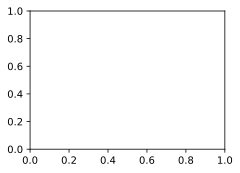

In [5]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

#@save
class TransformerEncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(TransformerEncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                TransformerEncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

class TransformerDecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(TransformerDecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                TransformerDecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)


    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        print("enc_X.dtype:", enc_X.dtype)
        print("enc_X.shape:", enc_X.shape)
        print("dec_X.dtype:", dec_X.dtype)
        print("dec_X.shape:", dec_X.shape)
        print(enc_X)
        print(dec_X)
        print("enc_outputs.shape:", enc_outputs.shape)
        print("dec_state[0].shape:", dec_state[0].shape)
        print("dec_state[1].shape:", dec_state[1].shape)
        print(dec_state[1])
        raise RuntimeError("aaa")
        return self.decoder(dec_X, dec_state)


num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, torch.device('cuda')
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = d2l.TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)